# [프로젝트] 인물 모드 문제점 찾기
### Step 1. 인물모드 직접 해보기

- `최소 3장 이상 인물모드 사진(사람, 동물 가능)` !!!
- 배경 blur 인물모드 말고 배경사진을 다른 이미지로 교체하는 `크로마키 배경 합성 시도` !!!

### Step 2. 사진에서 문제점 찾기

- 인물 영역에 포함되어 상관없는 옷이 blur 되지 않고 나오는 경우
- 이상한 점 2개 더 찾기( `표시한 이미지 jupyter notebook에 포함해 제출` !!!)

### Step 3. 해결 방법을 제안해보기

- 인물모드 사진의 `문제점을 해결할 방안을 정리해 제안` !!!
    - DeepLab 모델의 Semantic Segmentation Mask 영역 적용의 문제점을 보완하는 솔루션
- 세그멘테이션의 한계
- 피사계 심도 이해하기
    - 아웃포커싱 하는 법
    - 얕은 피사계 심도 촬영의 이해
- 3D 카메라 활용하기
- 소프트웨어 기술 활용하기
- 다른 기술과 융합해보기

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

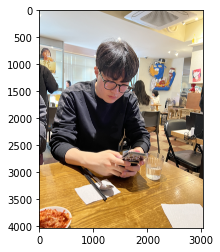

In [3]:
my_img_path = os.getenv('HOME')+'/aiffel/Aiffel_quest_rs/Exploration/Ex04/images/glassesmh.jpg'  
img_orig = cv2.imread(my_img_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 시맨틱 세그멘테이션 적용
DeepLab 세그멘테이션 모델 이용

In [4]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7dd3418ec190>)

In [5]:
# pixelLib 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(my_img_path)

### PASCAL VOC 데이터
PASCAL VOC 데이터로 학습된 모델 이용

In [6]:
# PASCAL 데이터의 Label 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

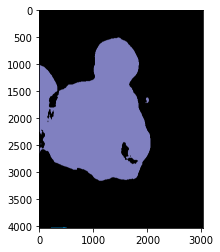

In [8]:
# semgentAspascalvoc() 함수 호출 -> 입력 이미지 분할 후 나온 결과값 시각화
rotated_output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(rotated_output)
plt.show()

In [9]:
# 입력 이미지 분할 후 결과 값 중 배열 값 출력
segvalues

{'class_ids': array([ 0, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
# class_ids에 담겨있는 값을 pascalvoc 담겨있는 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
diningtable
person


In [11]:
# pixelLib 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
# zjffjapq 15 배열 출력. 이처럼 다른 물체들을 찾는데 사용
colormap[15]

array([192, 128, 128])

(4032, 3024)


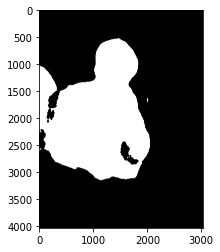

In [13]:
# BGR 순서로 채널 배치가 되어 있기에 RGB 순으로 돌림
seg_color = (128,128,192)

# 출력값 픽셀별 색상=seg_color -> 1(True) , 픽셀별 색상!=seg_color -> 0(False)
# seg_color 값은 사람을 나타냄. 사람 위치 제외 gray로 출력해야함
seg_map = np.all(rotated_output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

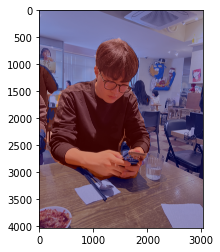

In [14]:
# 원래 이미지와 겹쳐 세그멘테이션 확인
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기

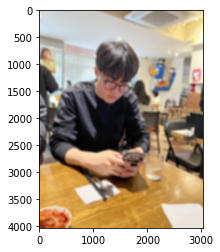

In [19]:
# `blur()` 함수 사용해 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (50,50)) # 해상도가 높아서 그런지 블러가 잘 안되서 50 높이기
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

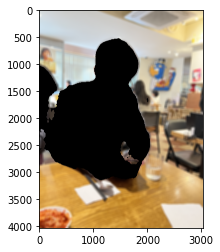

In [20]:
# 원본(BGR) -> 이미지 색상 채널(RGB) 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 배경 0, 사람 255 -> 배경 255, 사람 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and(): 배경만 있는 영상 얻기 => 사람이 사라지고 배경만 남음
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

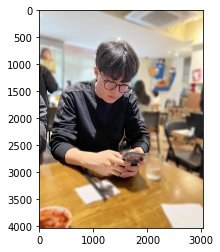

In [21]:
# np.where() 로 세그멘테이션 마스크 255부분만 원본 이미지 값을 가져옴. 아닌 영역은 블러된 이미지
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# cv2.COLOR_BGR2RGB: BGR 형식 -> RGB 형식으로 변경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 사람->블러, 배경->원본 해보기

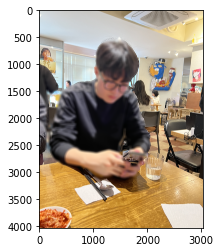

In [22]:
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 배경전환 크로마키 사진
### 절차
1. 세그멘테이션 마스크를 사용해 사람 영역과 배경 영역을 분리.
2. 배경 이미지를 준비하고, 원본 이미지와 크기가 같도록 맞추기.
3. 사람 영역은 원본 이미지에서 유지하고, 배경 영역은 새로운 이미지로 대체.

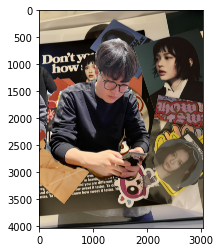

In [24]:
# img_background 는 크로마키
back_img_path = os.getenv('HOME')+'/aiffel/Aiffel_quest_rs/Exploration/Ex04/images/hannie_cd.JPG'  
img_background = cv2.imread(back_img_path)

img_background_resized = cv2.resize(img_background, (img_orig.shape[1], img_orig.shape[0]))

# np.where를 사용하여 사람 부분은 원본 이미지, 배경 부분은 새로운 배경 이미지로 교체
img_concat = np.where(img_mask_color == 255, img_orig, img_background_resized)

# 이미지를 시각화
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 동물 사진 인물 모드
내 상징과 같은 검은고양이를 아웃포커싱 해보겠다.

좀 더 구별하기 위해 귀여운 옷을 입혀봤다 =.=

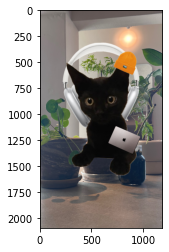

In [33]:
# 이미지 및 모델 경로 설정
image_path = os.getenv('HOME') + '/aiffel/Aiffel_quest_rs/Exploration/Ex04/images/HIPhaan.JPG'
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 모델 다운로드
if not os.path.exists(model_file):
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)

# 원본 이미지 로드
img_original = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.show()

# PixelLib 세그멘테이션 모델 로드 및 실행
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 이미지 세그멘테이션 수행
segmentation_result, segmentation_output = model.segmentAsPascalvoc(image_path)

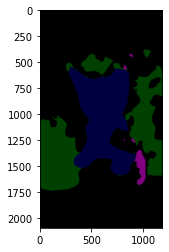

In [34]:
plt.imshow(segmentation_output)
plt.show()

In [42]:
segmentation_result

{'class_ids': array([ 0,  5,  8, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [43]:
for class_id in segmentation_result['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
cat
pottedplant


In [45]:
# pixelLib 컬러맵 만들기 
colormap1 = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap1[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap1[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [56]:
colormap1[8]

array([64,  0,  0])

(2096, 1179)


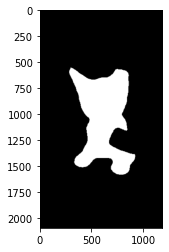

In [57]:
# BGR 순서로 채널 배치가 되어 있기에 RGB 순으로 돌림
seg_color1 = (0,0,64)

# 출력값 픽셀별 색상=seg_color1 -> 1(True) , 픽셀별 색상!=seg_color -> 0(False)
# seg_color1 값은 고양이을 나타냄. 고양이 위치 제외 gray로 출력해야함
seg_map1 = np.all(segmentation_output==seg_color1, axis=-1) 
print(seg_map1.shape) 
plt.imshow(seg_map1, cmap='gray')
plt.show()

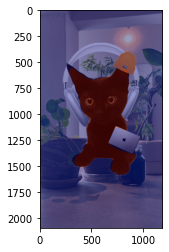

In [59]:
cat_img_show = img_original.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
cat_mask = seg_map1.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
cat_color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

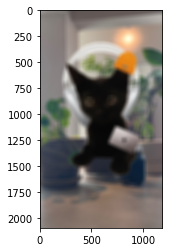

In [60]:
cat_orig_blur = cv2.blur(img_original, (50,50)) # 해상도가 높아서 그런지 블러가 잘 안되서 50 높이기
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

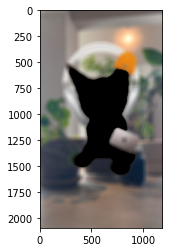

In [61]:
cat_mask_color = cv2.cvtColor(cat_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 배경 0, 사람 255 -> 배경 255, 사람 0
cat_bg_mask = cv2.bitwise_not(cat_mask_color)

# cv2.bitwise_and(): 배경만 있는 영상 얻기 => 사람이 사라지고 배경만 남음
cat_bg_blur = cv2.bitwise_and(cat_orig_blur, cat_bg_mask)
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

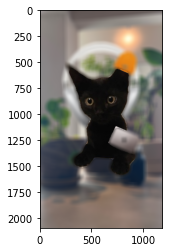

In [62]:
# np.where() 로 세그멘테이션 마스크 255부분만 원본 이미지 값을 가져옴. 아닌 영역은 블러된 이미지
cat_concat = np.where(cat_mask_color==255, img_original, cat_bg_blur)

# cv2.COLOR_BGR2RGB: BGR 형식 -> RGB 형식으로 변경
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 인물모드 사진들에 나타내는 문제점
1. 객체 간 구분 불가능
2. 경계 정확도 부족
3. 데이터 레이블링의 어려움

### 1. 객체 간 구분 불가능
시맨틱 세그멘테이션은 같은 클래스에 속하는 객체들을 동일하게 취급한다.

이 이미지에도 옆의 사람의 전체 모습은 나오지 않았지만, 형태를 통해 동일하게 취급하여 같은 객체로 처리한 것을 볼 수 있다.
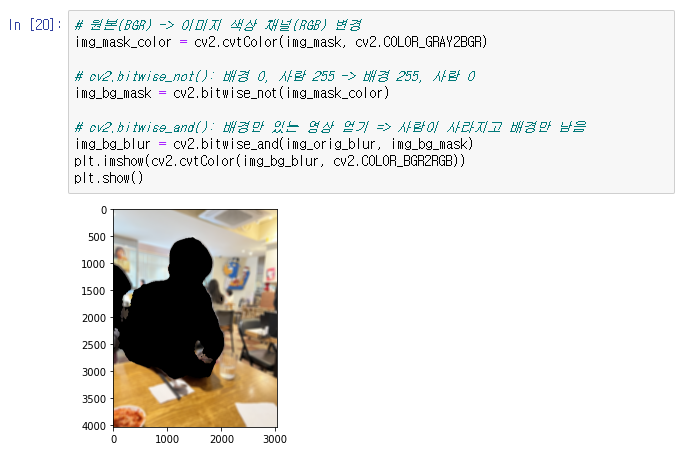

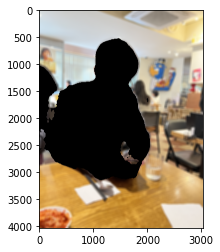

In [64]:
# 원본(BGR) -> 이미지 색상 채널(RGB) 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 배경 0, 사람 255 -> 배경 255, 사람 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and(): 배경만 있는 영상 얻기 => 사람이 사라지고 배경만 남음
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 경계 정확도 부족
객체의 경계 영역에서 정확도가 떨어질 수 있다. 

복잡한 경계나 물체의 세부적인 모양을 세밀하게 처리하기 어려워서, 객체의 경계선이 흐릿하거나 잘못 분류되는 경우가 발생하는 것 같다.
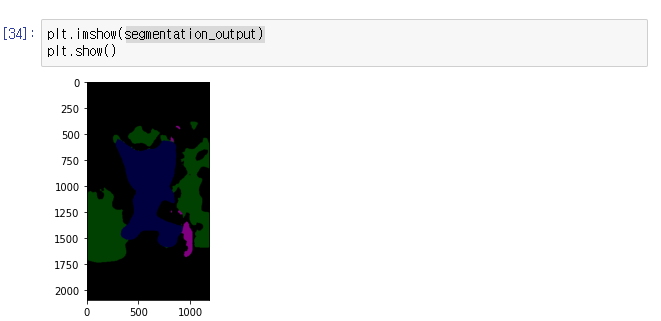

### 3. 데이터 레이블링의 어려움
```
background
bottle
cat
pottedplant
으로 이미지 영상에 대한 레이블링을 해도 정확하지 않다.
학습 데이터는 픽셀 단위로 각 클래스가 정확하게 레이블링 되어야 하는데
이 작업은 매우 시간과 비용이 많이 드는 작업이기 때문에 어렵다.
```
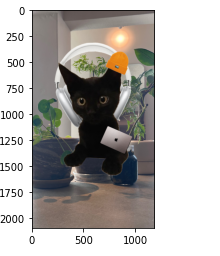

In [65]:
for class_id in segmentation_result['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
cat
pottedplant


이미지에서는 실제 고양이, 화분, 노트북, 헤드셋, 모자, 전구 등이 존재한다.

하지만 bottle 처럼 노트북 클래스 레이블링이 없기에 잘못 분류된다.

## 문제점 개선 솔루션
### 1. 경계 정확도 향상하는 방법
- CRF(Condition Random Field)
- Edge-aware Networks
    - 이 방법들은 경계부분을 더 세밀하게 분류해 정확도를 높인다.
- Atrous Convoloution
    - 확장(Atrous) 합성곱을 사용하면 객체의 작은 특징과 큰 특징을 동시에 추출할 수 있어 경꼐 처리가 개선된다.
    
### 2. 후처리 단계 추가
- Bilateral Filtering: 세그멘테이션 결과에서 경계를 더 부드럽게 만들기 위해 양방향 필터링을 적용할 수 있다.
- Modrphological Operations: `error` , `dilate` , `opening` , `closing` 등의 형태학적 연산을 적용해 마스크의 잡음이나 작은 결함을 제거할 수 있다.

### 회고

아이폰으로 인물사진을 많이 찍어봤는데, 프로젝트를 하면서 segmentation 원리로도 아웃포커싱이 되고 화면을 블러처리해 대상을 강조할 수 있는 경험이 아주 재밌었다. 정적인 화면 말고, 실시간 카메라처럼 보여지는 실시간 아웃포커싱도 해보고 싶다는 생각이 들었다.